In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from rich import print
import os

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import models

In [3]:
# Device-Agnostic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"""
Device: {device}
Device CUDNN enabled: {torch.backends.cudnn.enabled}
""")

Device: cuda
Device CUDNN enabled: True

In [4]:
IMG_WIDTH = 320
IMG_HEIGHT = 240

DATASET_ROOT = "datasets"
DATASET_FILE = DATASET_ROOT + "/preprocessed_dataset.csv"

dataset = pd.read_csv(DATASET_FILE)

# SKELETON = []

In [5]:
dataset.head()

,behavior,image_id,image_file,head_x,head_y,beak_base_x,beak_base_y,beak_tip_x,beak_tip_y,neck_x,neck_y,body1_x,body1_y,body2_x,body2_y,tail_base_x,tail_base_y
0,nesting,n_001,59-20151230231705-00.jpg,19.234443,92.112384,41.246921,134.089668,39.711167,149.447212,61.211727,86.993203,79.640779,136.137341,123.153818,131.530078,176.393301,7.133978
1,nesting,n_001,59-20151230231706-00.jpg,12.579507,49.111263,43.806512,116.684453,55.580628,136.137341,70.426253,83.921694,83.736124,139.208850,145.166297,131.018160,164.619185,5.086305
2,nesting,n_001,59-20151230231714-00.jpg,24.865542,28.634538,38.175412,83.921694,35.615822,99.279237,61.211727,54.742362,86.295715,137.161177,139.535198,132.553914,193.286599,5.086305
3,nesting,n_001,59-20151230231720-00.jpg,23.841705,105.934174,38.175412,120.267882,42.270757,127.946653,49.949529,112.589110,73.497762,132.553916,111.379702,121.291718,126.225327,-0.544792
4,nesting,n_001,59-20151230231721-00.jpg,26.913214,101.838830,37.151576,117.708291,44.318430,125.387062,51.997201,109.005683,66.842826,139.720769,104.212848,131.018162,141.070952,3.550553


In [6]:
class PoseDataset(Dataset):
    def __init__(self, dataframe, dataset_root_folder, img_transform=None, kp_transform=None):
        self.annotations = dataframe  # Load the pandas DataFrame directly
        self.dataset_root_folder = dataset_root_folder  # Root folder for the dataset
        self.img_transform = img_transform
        self.kp_transform = kp_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Construct the image path from behavior, image_id, and image_file columns
        behavior = self.annotations.iloc[idx]['behavior']
        image_id = self.annotations.iloc[idx]['image_id']
        image_file = self.annotations.iloc[idx]['image_file']
        
        # Create the full image path
        img_path = os.path.join(self.dataset_root_folder, behavior, image_id, image_file)
        
        # Load and process the image
        image = Image.open(img_path).convert("RGB")
        
        # Extract the keypoints (head_x, head_y, ..., body2_x, body2_y) as numpy array
        keypoints = self.annotations.iloc[idx, 3:].values.astype('float32')
        
        if self.img_transform:
            image = self.img_transform(image)

        if self.kp_transform:
            keypoints = self.kp_transform(keypoints)
        

        return image, keypoints


In [7]:
class BirdPoseResNet50(nn.Module):
    def __init__(self, num_keypoints: int = 7, pretrained: bool = True, fine_tune: bool = True):
        super(BirdPoseResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_keypoints * 2)
        )


        if not fine_tune:
            self.resnet.requires_grad_(True)
            self.resnet.fc.requires_grad_(True)
            self.resnet.layer3.requires_grad_(False)
            self.resnet.layer4.requires_grad_(True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet(x)

# Instantiate the model
model = BirdPoseResNet50(num_keypoints=7)
model = model.to(device)

In [8]:
print("__LAYER_1__")
print(model.resnet.layer1)

__LAYER_1__

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (2): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
)

In [9]:
print("__LAYER_2__")
print(model.resnet.layer2)

__LAYER_2__

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (2): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (3): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
)

In [10]:
print("__LAYER_4__")
print(model.resnet.layer4)

__LAYER_4__

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (2): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
)

In [11]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm  # Import tqdm for progress bars
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning rate scheduler

def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=10, accuracy_threshold=5.0):
    model.train()  # Set model to training mode
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_correct = 0
        total_keypoints = 0

        # One progress bar per epoch
        pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch", leave=False)
        
        for images, keypoints in pbar:
            images = images.to(device)  # Move images to GPU
            keypoints = keypoints.to(device)  # Move keypoints to GPU

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, keypoints)

            # Backward pass and optimization
            loss.backward()  # Compute gradients
            optimizer.step() # Update model parameters

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)

        # Print epoch metrics after all batches are processed
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


In [12]:
# Calculate aspect ratio
width = 320
height = 240
aspect_ratio = width / height
aspect_ratio

1.3333333333333333

In [13]:
new_width = 256
new_height = int(new_width / aspect_ratio)  # Keeps the aspect ratio
print(f"New width: {new_width} x New height: {new_height}")

New width: 256 x New height: 192

In [14]:
# padding
diff = 256 - new_height
top_pad = diff/2
bottom_pad = diff/2

top_pad, bottom_pad

(32.0, 32.0)

In [15]:
dataset.head(2)

,behavior,image_id,image_file,head_x,head_y,beak_base_x,beak_base_y,beak_tip_x,beak_tip_y,neck_x,neck_y,body1_x,body1_y,body2_x,body2_y,tail_base_x,tail_base_y
0,nesting,n_001,59-20151230231705-00.jpg,19.234443,92.112384,41.246921,134.089668,39.711167,149.447212,61.211727,86.993203,79.640779,136.137341,123.153818,131.530078,176.393301,7.133978
1,nesting,n_001,59-20151230231706-00.jpg,12.579507,49.111263,43.806512,116.684453,55.580628,136.137341,70.426253,83.921694,83.736124,139.208850,145.166297,131.018160,164.619185,5.086305


In [16]:
class NormalizeKeypoints:
    def __init__(self, image_width: int, image_height: int):
        self.image_width = image_width
        self.image_height = image_height

    def __call__(self, keypoints):
        # Convert to tensor if not already a tensor
        keypoints = torch.tensor(keypoints, dtype=torch.float32) if not isinstance(keypoints, torch.Tensor) else keypoints
        
        keypoints[0::2] /= self.image_width  # Normalize x-coordinates
        keypoints[1::2] /= self.image_height  # Normalize y-coordinates
        return keypoints


class DenormalizeKeypoints:
    def __init__(self, image_width: int, image_height: int):
        self.image_width = image_width
        self.image_height = image_height

    def __call__(self, keypoints):
        # Convert to tensor if not already a tensor
        keypoints = torch.tensor(keypoints, dtype=torch.float32) if not isinstance(keypoints, torch.Tensor) else keypoints
        
        keypoints[0::2] *= self.image_width  # Denormalize x-coordinates
        keypoints[1::2] *= self.image_height  # Denormalize y-coordinates
        return keypoints


In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Image Transformations Defination
img_transform = transforms.Compose([
    transforms.Resize((240, 320)),  # Resize to 320x240
    transforms.ToTensor(),            # Convert to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

kp_transform = NormalizeKeypoints(IMG_WIDTH, IMG_HEIGHT)

# Initialize the dataset and dataloader
pose_dataset = PoseDataset(dataframe=dataset, dataset_root_folder=DATASET_ROOT, img_transform=img_transform, kp_transform=kp_transform)
dataloader = DataLoader(pose_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)

In [18]:
single = pose_dataset[0]

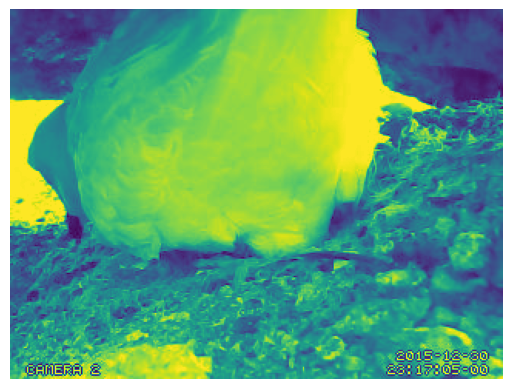

In [19]:
# Convert the tensor to a PIL image
to_pil = transforms.ToPILImage()
image_pil = to_pil(single[0][0])

#Display the image using matplotlib
plt.imshow(image_pil)
plt.axis('off')  # Hide axes
plt.show()

In [20]:
# check dataloader
img, key = next(iter(dataloader))
img

tensor([[[[0.2824, 0.2745, 0.2588,  ..., 0.2235, 0.2353, 0.2471],
          [0.2941, 0.2902, 0.2824,  ..., 0.2078, 0.2275, 0.2431],
          [0.2941, 0.3020, 0.3020,  ..., 0.1882, 0.2078, 0.2275],
          ...,
          [0.6588, 0.6941, 0.7333,  ..., 0.7294, 0.7529, 0.7608],
          [0.7216, 0.7059, 0.7373,  ..., 0.8353, 0.8941, 0.9451],
          [0.7765, 0.7020, 0.7059,  ..., 0.9529, 0.9804, 1.0000]],

         [[0.2392, 0.2314, 0.2235,  ..., 0.1725, 0.1843, 0.1961],
          [0.2510, 0.2471, 0.2431,  ..., 0.1569, 0.1765, 0.1922],
          [0.2549, 0.2627, 0.2627,  ..., 0.1412, 0.1608, 0.1804],
          ...,
          [0.6471, 0.6824, 0.7137,  ..., 0.6824, 0.7059, 0.7137],
          [0.7176, 0.7020, 0.7216,  ..., 0.7922, 0.8510, 0.9020],
          [0.7765, 0.7020, 0.6863,  ..., 0.9098, 0.9373, 0.9569]],

         [[0.2314, 0.2235, 0.2039,  ..., 0.1098, 0.1176, 0.1294],
          [0.2431, 0.2392, 0.2353,  ..., 0.0941, 0.1098, 0.1255],
          [0.2510, 0.2549, 0.2549,  ..., 0

In [22]:
# Training the model
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning rate scheduler

loss_fn = nn.SmoothL1Loss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_model(model=model, dataloader=dataloader, optimizer=optimizer, criterion=loss_fn, num_epochs=1, scheduler=scheduler)

Epoch [1/1], Loss: 0.1139

In [51]:
denormal_kp = DenormalizeKeypoints(IMG_WIDTH, IMG_HEIGHT)
x_test = []
for x, y in dataloader:
    x_test = x
    print(x[0])
    print(denormal_kp(y[0]))
    break

tensor([[[0.2824, 0.2745, 0.2588,  ..., 0.2235, 0.2353, 0.2471],
         [0.2941, 0.2902, 0.2824,  ..., 0.2078, 0.2275, 0.2431],
         [0.2941, 0.3020, 0.3020,  ..., 0.1882, 0.2078, 0.2275],
         ...,
         [0.6588, 0.6941, 0.7333,  ..., 0.7294, 0.7529, 0.7608],
         [0.7216, 0.7059, 0.7373,  ..., 0.8353, 0.8941, 0.9451],
         [0.7765, 0.7020, 0.7059,  ..., 0.9529, 0.9804, 1.0000]],

        [[0.2392, 0.2314, 0.2235,  ..., 0.1725, 0.1843, 0.1961],
         [0.2510, 0.2471, 0.2431,  ..., 0.1569, 0.1765, 0.1922],
         [0.2549, 0.2627, 0.2627,  ..., 0.1412, 0.1608, 0.1804],
         ...,
         [0.6471, 0.6824, 0.7137,  ..., 0.6824, 0.7059, 0.7137],
         [0.7176, 0.7020, 0.7216,  ..., 0.7922, 0.8510, 0.9020],
         [0.7765, 0.7020, 0.6863,  ..., 0.9098, 0.9373, 0.9569]],

        [[0.2314, 0.2235, 0.2039,  ..., 0.1098, 0.1176, 0.1294],
         [0.2431, 0.2392, 0.2353,  ..., 0.0941, 0.1098, 0.1255],
         [0.2510, 0.2549, 0.2549,  ..., 0.0784, 0.0980, 0.1176],
         ...,
         [0.5255, 0.5608, 0.6000,  ..., 0.5804, 0.6039, 0.6118],
         [0.6000, 0.5922, 0.6235,  ..., 0.6824, 0.7412, 0.7922],
         [0.6667, 0.5922, 0.6000,  ..., 0.8000, 0.8196, 0.8392]]])

tensor([ 19.2344,  92.1124,  41.2469, 134.0897,  39.7112, 149.4472,  61.2117,
         86.9932,  79.6408, 136.1373, 123.1538, 131.5301, 176.3933,   7.1340])

In [56]:
# Function to make predictions
def predict(model: BirdPoseResNet50, image_tensor: torch.Tensor) -> torch.Tensor:
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Disable gradient calculation
        image_tensor = image_tensor.to(device)  # Move image to GPU if available
        keypoints = denormal_kp(model(image_tensor))           # Forward pass
    return keypoints

In [58]:
print(predict(model, x_test))

tensor([[  19.0613,  432.5091,  489.4564,  274.9564,  142.5444,  244.8419,
          316.3359, -116.1114,  407.6265,  234.3701,  368.4438,  726.9385,
          815.9871, -181.9704],
        [ 259.6299,  433.3105,  346.0751,  149.3583,  146.8583,   59.7735,
          286.5943,   10.0411,  154.9462,  189.1852,  244.2612,  537.8288,
          429.7713,  -52.3072]], device='cuda:0')